# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, countDistinct, \
    min, max, avg, split, round, lit, row_number
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType, BooleanType
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

### Common Functions

In [4]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

def get_user_logs(userId, sessionId=None):
    if sessionId == None:
        return data.where(data.userId == userId) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')
    else:
        return data.where((data.userId == userId) & (data.sessionId == sessionId)) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
#data = data.drop('method')

data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

data.printSchema()
data.take(3)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', regDate=datetime.datetime(2018, 9, 29, 0, 22, 42), tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57), city='Bakersfield', state=' CA'),
 Row(artist='Five Iron Frenzy', auth='Logged In', gender='M', itemInSession=79, length=236.09424, level='free', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', regDate=datetime.datetime(2018, 9, 30, 20, 20, 30), tsDate=datetime.datetime(2018, 10, 1, 2, 3), city='Boston-Cambridge-Newton', state=' MA-NH'),
 Row(artist='Adam Lamber

In [24]:
# Combination
data.select('firstName', 'lastName').dropDuplicates().count()

225

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### EDA on churned users

In [5]:
# Count churned users using Cancellation Confirmation evet
data.where(data.page == 'Cancellation Confirmation').dropDuplicates().count()

52

In [4]:
# Is one CC event per user? - yes 
data.where(data.page == 'Cancellation Confirmation') \
    .groupby('userid') \
    .count() \
    .where(col('count') > 1) \
    .count()

0

In [8]:
# Label churned users

# extract churned users
churned = data.where(data.page.isin(['Cancellation Confirmation'])) \
    .dropDuplicates() \
    .select('userId') \
    .collect()

# add new column using churned list
churned_uids = [x.userId for x in churned];
is_churn = udf(lambda x: 1 if x in churned_uids else 0, IntegerType())
data = data.withColumn('churn', is_churn('userId'))
data.take(3)

# check
data.where(data.churn == True).select('userId').dropDuplicates().count()

52

In [12]:
# Is one downgrade event per user?
data.where(data.page == 'Submit Downgrade') \
    .groupby('userid') \
    .count() \
    .where(col('count') > 1) \
    .show()

+------+-----+
|userid|count|
+------+-----+
|    85|    2|
|    35|    2|
|    61|    2|
|   131|    2|
|   140|    3|
|100004|    2|
|200003|    2|
|200023|    2|
|    20|    2|
|    39|    3|
|    13|    2|
|100018|    2|
+------+-----+



In [15]:
get_user_logs(140).where(data.page == 'Submit Downgrade').show()

+-------------------+------+---------+-------------+-----+----------------+
|             tsDate|userId|sessionId|itemInSession|level|            page|
+-------------------+------+---------+-------------+-----+----------------+
|2018-10-12 11:43:03|   140|      753|           19| paid|Submit Downgrade|
|2018-11-06 18:04:05|   140|     1643|          163| paid|Submit Downgrade|
|2018-11-15 15:08:10|   140|     1918|          229| paid|Submit Downgrade|
+-------------------+------+---------+-------------+-----+----------------+



#### userRowId, userRowDescId
We cannot rely on itemInSession, so we create 2 user-window indexes, one in ascending and the other in descending order 

In [43]:
data.where(data.itemInSession == 0).select('sessionId').dropDuplicates().count()

2037

In [47]:
data.groupby('sessionId') \
    .agg(min('itemInSession').alias('firstItemInSession')) \
    .where(col('firstItemInSession') != 0) \
    .sort(desc('firstItemInSession')) \
    .show(5)

+---------+------------------+
|sessionId|firstItemInSession|
+---------+------------------+
|        8|                79|
|       29|                50|
|     2288|                 9|
|     2164|                 6|
|     2102|                 4|
+---------+------------------+
only showing top 5 rows



In [49]:
data.where(data.sessionId == 8).select('ts', 'userId', 'sessionId', 'itemInSession').show(5)

+-------------+------+---------+-------------+
|           ts|userId|sessionId|itemInSession|
+-------------+------+---------+-------------+
|1538352180000|     9|        8|           79|
|1538352416000|     9|        8|           80|
|1538352678000|     9|        8|           81|
|1538352886000|     9|        8|           82|
|1538353146000|     9|        8|           83|
+-------------+------+---------+-------------+
only showing top 5 rows



In [6]:
# userRowid
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# userRowDescId
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

data.take(3)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', userRowId=381, userRowDescId=1),
 Row(artist='Lily Allen', auth='Logged In', gender='F', itemInSession=33, length=185.25995, level='free', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40

In [6]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- userRowId: integer (nullable = true)
 |-- userRowDescId: integer (nullable = true)



#### Is Cancellation Confirmation always the last event in the user log history?

In [ ]:
## yes
data.where((data.page == 'Cancellation Confirmation') & (data.userRowDescId == 1)).dropDuplicates().count()

In [80]:
data.where(data.page == 'Cancellation Confirmation').select('userRowId', 'userId', 'level').show(52)

+---------+------+-----+
|userRowId|userId|level|
+---------+------+-----+
|       11|   125| free|
|     2464|    51| paid|
|     3437|    54| paid|
|      310|100014| paid|
|     2149|   101| paid|
|      319|100021| free|
|     3603|    29| paid|
|      457|    73| paid|
|     1003|    87| paid|
|      254|     3| paid|
|     1781|    28| paid|
|      964|100022| free|
|      623|100025| free|
|      143|300007| paid|
|       44|100006| free|
|      513|    18| paid|
|     1775|    70| paid|
|      216|100005| free|
|     1102|    17| paid|
|      520|100007| paid|
|     2168|300001| paid|
|      671|100009| free|
|     1050|100015| paid|
|      552|200024| paid|
|       78|100003| free|
|     1310|   103| paid|
|       36|100024| free|
|     2064|    53| paid|
|       62|   122| paid|
|      620|200017| paid|
|     2027|    58| paid|
|       23|100011| free|
|       89|100019| free|
|      600|100012| free|
|      478|200018| free|
|      268|200016| free|
|     1498|200020| free|


#### lastLevel

In [7]:
# last user level in the log history
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
len(last_levels)

get_level = udf(lambda userId: last_levels[userId] )
data = data.withColumn('lastLevel', get_level('userId'))
data.take(3)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', userRowId=381, userRowDescId=1, lastLevel='free'),
 Row(artist='Lily Allen', auth='Logged In', gender='F', itemInSession=33, length=185.25995, level='free', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018

In [23]:
# All last levels are OK
data.where(data.userRowDescId == 1).select('userId', 'level', 'lastLevel').show(225)

+------+-----+---------+
|userId|level|lastLevel|
+------+-----+---------+
|100010| free|     free|
|200002| paid|     paid|
|   125| free|     free|
|   124| paid|     paid|
|    51| paid|     paid|
|     7| free|     free|
|    15| paid|     paid|
|    54| paid|     paid|
|   155| paid|     paid|
|100014| paid|     paid|
|   132| paid|     paid|
|   154| free|     free|
|   101| paid|     paid|
|    11| paid|     paid|
|   138| paid|     paid|
|300017| paid|     paid|
|100021| free|     free|
|    29| paid|     paid|
|    69| paid|     paid|
|   112| free|     free|
|    42| paid|     paid|
|    73| paid|     paid|
|    87| paid|     paid|
|200010| free|     free|
|    64| free|     free|
|     3| paid|     paid|
|   113| paid|     paid|
|    30| paid|     paid|
|    34| free|     free|
|   133| free|     free|
|    59| paid|     paid|
|   139| paid|     paid|
|   146| free|     free|
|     8| free|     free|
|    22| free|     free|
|    28| paid|     paid|
|300018| paid|     paid|


In [26]:
# check if there is only 1 last level per user - OK
data \
    .select('userId', 'lastLevel') \
    .dropDuplicates() \
    .groupby('userId') \
    .count() \
    .where(col('count') > 1) \
    .show()

+------+-----+
|userId|count|
+------+-----+
+------+-----+



#### Churn of Submit Downgrade event
We observe non-churned users who triggered Submit Downgrade event. These users are churned *at the end of the observation period* if their last level is **free**.

In [28]:
# Count log events
data.where(data.page == 'Submit Downgrade').count()

63

Does downgrade causes a change of level from *paid* to *free*?

In [30]:
# Is the SD entering level always paid? - Yes
data.where((data.page == 'Submit Downgrade') & (data.level == 'paid')).count()

63

In [ ]:
# Is the SD outgoing level always free?
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
len(last_levels)

get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))
data.take(3)

In [11]:
data.where(data.userId.isin([row.userId for row in data \
                             .where(data.page == 'Submit Downgrade') \
                             .select('userId').dropDuplicates().collect()])) \
    .groupby('userId') \
    .count() \
    .sort('count') \
    .show(10)

+------+-----+
|userId|count|
+------+-----+
|300004|  262|
|100012|  600|
|100025|  623|
|    24|  630|
|100016|  638|
|200019|  639|
|100009|  671|
|    11|  848|
|200011|  848|
|   109|  861|
+------+-----+
only showing top 10 rows



In [9]:
# Query churned users by downgrade event
downgraded = data.where((data.churn == 0) \
           & (data.page == 'Submit Downgrade') \
           & (data.lastLevel == 'free')) \
    .select('userId') \
    .dropDuplicates()

downgraded.show()

+------+
|userId|
+------+
|    35|
|100008|
|    61|
|   131|
|300004|
|200003|
|100016|
|    95|
|200009|
|    92|
|    24|
|   109|
|    13|
|200019|
|100018|
+------+



In [10]:
# Label downgraded users

# set downgraded users: churn=1
uids = [x.userId for x in downgraded.collect()]
is_downgraded = udf(lambda userId, churn: 1 if userId in uids else churn, IntegerType())
data = data.withColumn('churn', is_downgraded('userId', 'churn'))
data.take(3)

# check
data.where(data.churn == 1).select('userId').dropDuplicates().count()

67

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Log Level
By each target group (*active*, *churned*), count logs of each feature dividing by number of logs in a target group.

#### Global Variables

In [11]:
# Count of 'churned'/active logs
count0 = data.where(data.churn == 0).count()
count1 = data.where(data.churn == 1).count()

#### Common Functions

In [12]:
# Fetch values (categories) of a given feature
def get_categories(feature):
    return data.select(feature).dropDuplicates().sort(feature)

# Get list of categories of a given feature
def get_categories_list(feature):
    return [str(row[feature]) for row in get_categories(feature).collect()]

# Calculate share of each category relating to its churn group
def calc_log_share(feature):
    # calculate count of each category, per churn group
    df = data \
        .groupby('churn', feature) \
        .count() \
        .toPandas()
       
    totals = df.groupby('churn').sum()
    df = df.set_index('churn').join(totals, rsuffix='_total')
    df['share'] = df['count']/df['count_total']
    df = df.drop('count_total', axis=1)
    return df.reset_index()

# Plot the category share, for both churn group
def plot_share(df, feature):
    # split dataset into 3 churn subsets
    df0 = df[df.churn == 0].sort_values(by='share', ascending=False)
    df1 = df[df.churn == 1].sort_values(by='share', ascending=False)
    
    # plot
    width =0.35
    labels = get_categories_list(feature)
    plt.xticks(range(len(labels)), df0[feature])
    plt.xlabel(feature)
    plt.ylabel('share')
    plt.bar(np.arange(len(df0)), df0['share'], width=width)
    plt.bar(np.arange(len(df1)) + width, df1['share'], width=width)
    ax = plt.gca()
    ax.set_title('Log level: ' + feature);
    plt.legend(['non-churned', 'churned'], loc=1)

def plot_share3(df, feature):
    # split dataset into 3 churn subsets
    df0 = df[df.churn == 0].sort_values(by='share', ascending=False)
    df1 = df[df.churn == 1].sort_values(by='share', ascending=False)
    df2 = df[df.churn == 2].sort_values(by='share', ascending=False)
    
    # plot
    width =0.2
    labels = get_categories_list(feature)
    plt.xticks(range(len(labels)), df0[feature])
    plt.xlabel(feature)
    plt.ylabel('share')
    plt.bar(np.arange(len(df0)), df0['share'], width=width)
    plt.bar(np.arange(len(df1)) + width, df1['share'], width=width)
    plt.bar(np.arange(len(df2)) + 2*width, df2['share'], width=width)
    ax = plt.gca()
    ax.set_title('Log level: ' + feature);
    plt.legend(['non-churned', 'cancelled', 'downgraded'], loc=1)

#### Method, Status, Level

In [13]:
# get data
df_method = calc_log_share('method')
df_status = calc_log_share('status')
df_level = calc_log_share('level')

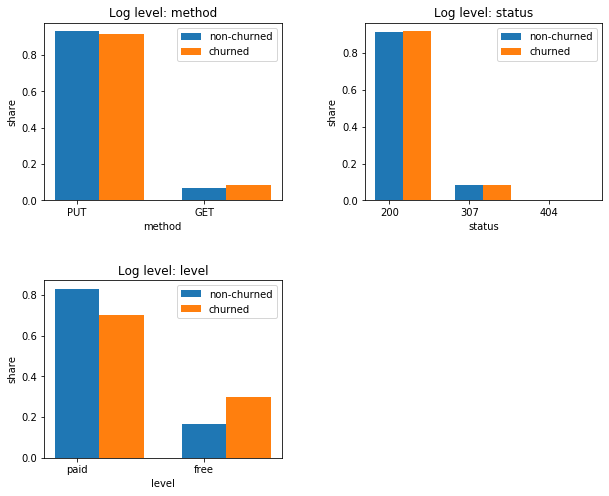

In [40]:
plt.figure(figsize = [10, 8]);
#fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.tight_layout() 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.45)

# method
plt.subplot(2, 2, 1)
plot_share(df_method, 'method')

# status
plt.subplot(2, 2, 2)
plot_share(df_status, 'status')

# level
plt.subplot(2, 2, 3)
plot_share(df_level, 'level')

plt.show()

#### Page: NextSong

In [29]:
get_total = udf(lambda x: count0 if x == 0 else count1 if x == 1 else count2)
df_nextSong = data.where(data.page == 'NextSong') \
    .withColumn('total', get_total('churn')) \
    .groupby('churn', 'total') \
    .count() \
    .withColumn('share', col('count')/col('total')) \
    .drop('total') \
    .toPandas()

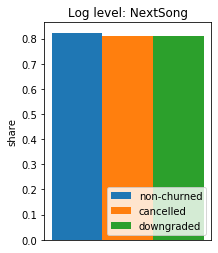

In [30]:
# split data by churn
df0 = df_nextSong[df_nextSong.churn == 0].copy()
df1 = df_nextSong[df_nextSong.churn == 1].copy()
df2 = df_nextSong[df_nextSong.churn == 2].copy()

# plot
plt.figure(figsize = [3, 4]);
width =0.1
plt.xticks(range(0), [])
plt.ylabel('share')
plt.bar(np.arange(1), df0['share'], width=width)
plt.bar(np.arange(1) + width, df1['share'], width=width)
plt.bar(np.arange(1) + 2*width, df2['share'], width=width)
ax = plt.gca()
ax.set_title('Log level: NextSong');
plt.legend(['non-churned', 'cancelled', 'downgraded'], loc=4)
plt.show()


#### Page: other

In [35]:
get_total = udf(lambda x: count0 if x == 0 else count1 if x == 1 else count2)
df_otherPages = data.where(~data.page.isin(['NextSong', 'Cancel', 'Cancellation Confirmation'])) \
    .withColumn('total', get_total('churn')) \
    .groupby('churn', 'total', 'page') \
    .count() \
    .withColumn('share', col('count')/col('total')) \
    .drop('total') \
    .toPandas()

In [36]:
df_otherPages.sort_values(['page', 'churn'])

,churn,page,count,share
15,0,About,382,0.001827
1,1,About,56,0.001248
26,2,About,57,0.002350
22,0,Add Friend,3258,0.015586
8,1,Add Friend,636,0.014176
14,2,Add Friend,383,0.015793
3,0,Add to Playlist,4900,0.023441
19,1,Add to Playlist,1038,0.023137
5,2,Add to Playlist,588,0.024245
33,0,Downgrade,1533,0.007334


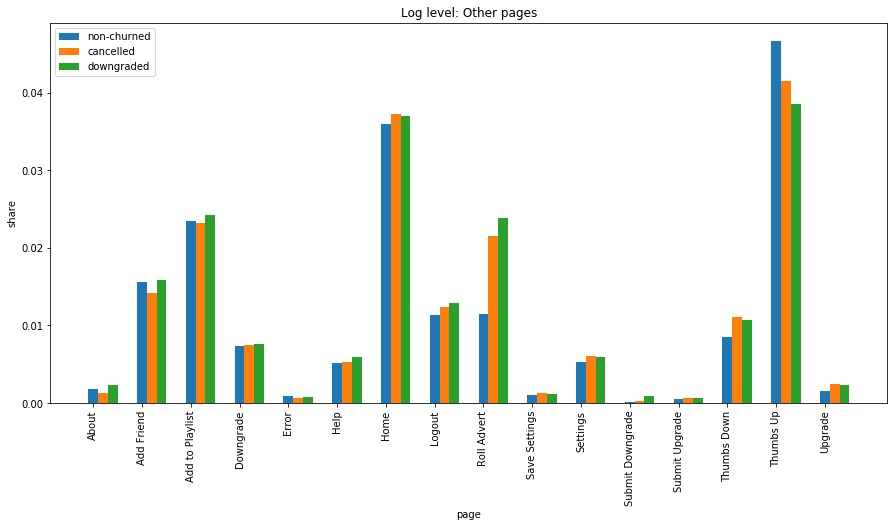

In [42]:
# split data by churn
df0 = df_otherPages[df_otherPages.churn == 0].sort_values(['page', 'churn']).copy()
df1 = df_otherPages[df_otherPages.churn == 1].sort_values(['page', 'churn']).copy()
df2 = df_otherPages[df_otherPages.churn == 2].sort_values(['page', 'churn']).copy()

# plot
plt.figure(figsize = [15, 7])
width = 0.20
labels = df0['page'].sort_values()
plt.xticks(range(len(labels)), labels)
plt.xlabel('page')
plt.ylabel('share')
plt.bar(np.arange(len(df0)), df0['share'], width=width)
plt.bar(np.arange(len(df1)) + width, df1['share'], width=width)
plt.bar(np.arange(len(df2)) + 2*width, df2['share'], width=width)
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title('Log level: Other pages');
plt.legend(['non-churned', 'cancelled', 'downgraded'], loc=2)
plt.show()

### User Level

In [44]:
# count users for each churn group 
split = data.groupby('churn', 'userId').count()
user_count0 = split.where(split.churn == 0).count()
user_count1 = split.where(split.churn == 1).count()
user_count2 = split.where(split.churn == 2).count()

In [45]:
print(user_count0)
print(user_count1)
print(user_count2)

158
52
15


#### User level: *Gender*

In [46]:
# prepare data
get_total = udf(lambda x: user_count0 if x == 0 else user_count1 if x == 1 else user_count2)
df_gender = data \
    .withColumn('total', get_total('churn')) \
    .groupby('churn', 'total', 'userId', 'gender') \
    .count() \
    .groupby('churn', 'total', 'gender') \
    .count() \
    .withColumn('share', col('count')/col('total')) \
    .drop('total') \
    .toPandas()

In [47]:
df_gender

,churn,gender,count,share
0,1,M,32,0.615385
1,0,M,82,0.518987
2,2,M,7,0.466667
3,2,F,8,0.533333
4,1,F,20,0.384615
5,0,F,76,0.481013


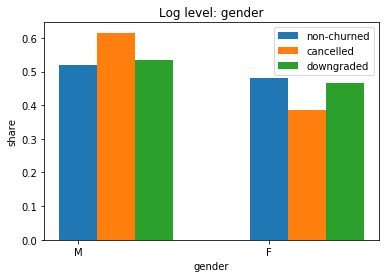

In [51]:
plot_share3(df_gender, 'gender')

#### User level: *Level*
Here we observe the user's level *at the end of the observation period* since level is user-time dependent feature.

In [70]:
data.where(data.userRowId == 1).count()

225

In [ ]:
# check first level
data.where(data.userRowId == 1) \
    .groupby('churn', 'level') \
    .count() \
    .show()

In [72]:
# check last level
data.where(data.userRowDescId == 1) \
    .groupby('churn', 'lastLevel') \
    .count() \
    .show()

+---------+-----+
|lastLevel|count|
+---------+-----+
|     free|   80|
|     paid|  145|
+---------+-----+



In [58]:
# prepare data
get_total = udf(lambda x: user_count0 if x == 0 else user_count1 if x == 1 else user_count2)
df_level = data \
    .withColumn('total', get_total('churn')) \
    .groupby('churn', 'total', 'userId', 'lastLevel') \
    .count() \
    .groupby('churn', 'total', 'lastLevel') \
    .count() \
    .withColumn('share', col('count')/col('total')) \
    .drop('total') \
    .toPandas()

In [63]:
df_level.sort_values(['churn', 'lastLevel'])

,churn,lastLevel,count,share
1,0,free,44,0.278481
2,0,paid,114,0.721519
0,1,free,21,0.403846
3,1,paid,31,0.596154
4,2,free,15,1.000000


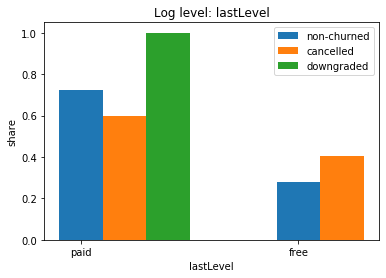

In [61]:
plot_share3(df_level, 'lastLevel')

### Check the level after churning event

In [11]:
cols = ['tsDate', 'sessionId', 'userId', 'churn', 'level', 'page', 'itemInSession', 'status']

In [ ]:
# add new, more exact 'itemInSession' column  
data.withColumn('maxTs', max('ts').over(w)) \
    .where(col('ts') == col('maxTs')) \
    .select('userId', 'maxTs', 'churn', 'level') \
    .sort('userId') \
    .show(50)

In [17]:
data.where((data.userId == 200025) & (data.userRowId.isin([86, 87]))).select(cols).show()

+-------------------+---------+------+-----+-----+----------------+-------------+------+
|             tsDate|sessionId|userId|churn|level|            page|itemInSession|status|
+-------------------+---------+------+-----+-----+----------------+-------------+------+
|2018-10-12 09:48:59|      115|200025|    0| paid|Submit Downgrade|           94|   307|
|2018-10-12 09:49:17|      115|200025|    0| free|            Home|           95|   200|
+-------------------+---------+------+-----+-----+----------------+-------------+------+



In [ ]:
data.where((data.userId == 25) & (data.userRowId.isin([1499, 1500]))).select(cols).show()

In [ ]:
#### Check how many downgraded users keeps Paid level in the last log

In [20]:
downgraded_users = [row.userId for row in data.join(downgraded, \
         (data.userId == downgraded.userId) & (data.userRowId == downgraded.userRowId + 1), "inner") \
    .select(data.userId) \
    .collect()]
downgraded_users

['300021',
 '81',
 '24',
 '300011',
 '100018',
 '300015',
 '38',
 '49',
 '9',
 '30',
 '74',
 '300002',
 '61',
 '96',
 '35',
 '300023',
 '92',
 '100004',
 '11',
 '39',
 '300004',
 '13',
 '200023',
 '141',
 '20',
 '200003',
 '200019',
 '100016',
 '85',
 '131',
 '109',
 '77',
 '59',
 '100008',
 '140',
 '200025',
 '200009',
 '100',
 '95',
 '25']

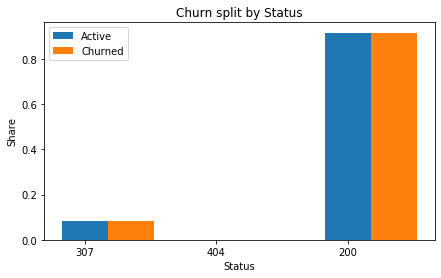

In [1630]:





# plot
plt.figure(figsize = [7, 4])
width =0.35
labels = get_categories_list(feature)
plt.xticks(range(len(df_log_status_0)), labels)
plt.xlabel('Status')
plt.ylabel('Share')
plt.bar(np.arange(len(df_log_status_0)), df_log_status_0['share'], width=width)
plt.bar(np.arange(len(df_log_status_1))+ width, df_log_status_1['share'], width=width)
ax = plt.gca()
ax.set_title('Churn split by Status');
plt.legend(['Active', 'Churned'], loc=2)
plt.show()

# Result: no split

#### NextSong

In [1631]:
feature = 'page'

In [1632]:
get_categories(feature).show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [1633]:
# prepare data
df_log_nextSong_0 = calc_log_share(data0, feature)
df_log_nextSong_1 = calc_log_share(data1, feature)

In [1637]:
df_log_nextSong_0[df_log_nextSong_0.page == 'NextSong']

,page,count,share
11,NextSong,191714,0.821784


In [1516]:
data0 \
    .groupby('method') \
    .count() \
    .withColumn('share', col('count')/N0) \
    .show()

+------+------+-------------------+
|method| count|              share|
+------+------+-------------------+
|   PUT|216691| 0.9288482146684385|
|   GET| 16599|0.07115178533156158|
+------+------+-------------------+



In [1488]:
# Method
get_total = udf(lambda x: N0 if x == 0 else N1)
df = data.withColumn('total', get_total('churn')) \
    .groupby('churn', 'total', 'method') \
    .count() \
    .withColumn('churnShare', col('count')/col('total')) \
    .drop('total') \
    .sort('churn', 'method') \
    .toPandas()

In [1496]:
# Status
get_total = udf(lambda x: N0 if x == 0 else N1)
data.withColumn('total', get_total('churn')) \
    .groupby('churn', 'total', 'status') \
    .count() \
    .withColumn('churnShare', col('count')/col('total')) \
    .drop('total') \
    .sort('churn', 'status') \
    .toPandas()

,churn,status,count,churnShare
0,0,200,213581,0.915517
1,0,307,19489,0.083540
2,0,404,220,0.000943
3,1,200,41137,0.916927
4,1,307,3695,0.082360
5,1,404,32,0.000713


In [1497]:
0.915517 + 0.083540 + 0.000943

1.0

In [1474]:
data \
    .groupby('churn', 'method') \
    .count() \
    .sort('churn', 'method') \
    .show()

+-----+------+------+
|churn|method| count|
+-----+------+------+
|    0|   GET| 16599|
|    0|   PUT|216691|
|    1|   GET|  3737|
|    1|   PUT| 41127|
+-----+------+------+



### Churn vs page activity

In [1347]:
# Prepare dataset
def get_df(page):
    return data.where(data.page == page) \
        .groupby('userId', 'churn', 'sessionId') \
        .agg(count('sessionId').alias('logCount')) \
        .groupby('userId', 'churn') \
        .agg(avg('logCount').alias(page)) \
        .toPandas()

In [1384]:
def get_churn_mean(page):
    return data.where(data.page == page) \
        .groupby('userId', 'churn', 'sessionId') \
        .agg(count('sessionId').alias('logCount')) \
        .groupby('userId', 'churn') \
        .agg(avg('logCount').alias(page)) \
        .groupby('churn') \
        .agg(avg(page))

In [1385]:
get_churn_mean('NextSong').show()

+-----+------------------+
|churn|     avg(NextSong)|
+-----+------------------+
|    1|63.537152578095224|
|    0| 72.96967249911357|
+-----+------------------+



In [1386]:
get_churn_mean('Thumbs Up').show()

+-----+------------------+
|churn|    avg(Thumbs Up)|
+-----+------------------+
|    1| 4.279693814443338|
|    0|4.9075917705904715|
+-----+------------------+



In [1387]:
get_churn_mean('Thumbs Down').show()

+-----+------------------+
|churn|  avg(Thumbs Down)|
+-----+------------------+
|    1| 1.838778453300512|
|    0|1.8282693906593053|
+-----+------------------+



In [1388]:
get_churn_mean('Add to Playlist').show()

+-----+--------------------+
|churn|avg(Add to Playlist)|
+-----+--------------------+
|    1|   2.942379760336282|
|    0|   3.195701432845371|
+-----+--------------------+



In [1389]:
get_churn_mean('Add Friend').show()

+-----+------------------+
|churn|   avg(Add Friend)|
+-----+------------------+
|    1|  2.63313529904439|
|    0|3.0522598254937874|
+-----+------------------+



In [1390]:
get_churn_mean('Roll Advert').show()

+-----+-----------------+
|churn| avg(Roll Advert)|
+-----+-----------------+
|    1|3.730709532297768|
|    0|3.097638542563953|
+-----+-----------------+



In [1400]:
get_churn_mean('Error').show()

+-----+------------------+
|churn|        avg(Error)|
+-----+------------------+
|    1|1.0681818181818181|
|    0|1.1289473684210525|
+-----+------------------+



In [1392]:
def get_churn_total_mean(page):
    return data.where(data.page == page) \
        .groupby('churn', 'userId') \
        .agg(count('churn').alias('logCount')) \
        .groupby('churn') \
        .agg(avg('logCount').alias(page))

In [1393]:
get_churn_total_mean('NextSong').show()

+-----+------------------+
|churn|          NextSong|
+-----+------------------+
|    1| 699.8846153846154|
|    0|1108.1734104046243|
+-----+------------------+



In [1394]:
get_churn_total_mean('Thumbs Up').show()

+-----+-----------------+
|churn|        Thumbs Up|
+-----+-----------------+
|    1|            37.18|
|    0|62.89411764705882|
+-----+-----------------+



In [1395]:
get_churn_total_mean('Thumbs Down').show()

+-----+------------------+
|churn|       Thumbs Down|
+-----+------------------+
|    1|10.333333333333334|
|    0|13.225806451612904|
+-----+------------------+



In [1396]:
get_churn_total_mean('Add to Playlist').show()

+-----+-----------------+
|churn|  Add to Playlist|
+-----+-----------------+
|    1|            20.76|
|    0|33.26060606060606|
+-----+-----------------+



In [1397]:
get_churn_total_mean('Add Friend').show()

+-----+------------------+
|churn|        Add Friend|
+-----+------------------+
|    1|14.454545454545455|
|    0| 22.47530864197531|
+-----+------------------+



In [1398]:
get_churn_total_mean('Roll Advert').show()

+-----+-----------------+
|churn|      Roll Advert|
+-----+-----------------+
|    1|            19.34|
|    0|18.89171974522293|
+-----+-----------------+



In [1399]:
get_churn_total_mean('Error').show()

+-----+------------------+
|churn|             Error|
+-----+------------------+
|    1|1.4545454545454546|
|    0|2.3157894736842106|
+-----+------------------+



In [1377]:
def plot_churn(page, kde=False):
    df = get_df(page)
    plt.figure(figsize=(12, 4))
    df_active = df[df.churn == 0][page]
    df_churned = df[df.churn == 1][page]
    plt.figure(figsize=(15,6));
    sb.distplot(df_active, bins=20, label='active', kde=kde);
    sb.distplot(df_churned, bins=20, label = 'churned', kde=kde);
    plt.xlabel('Average ' + page)
    ax = plt.gca()
    ax.set_title('Churn vs. Average ' + page);
    plt.legend(loc='upper right');
    plt.show()

<Figure size 864x288 with 0 Axes>

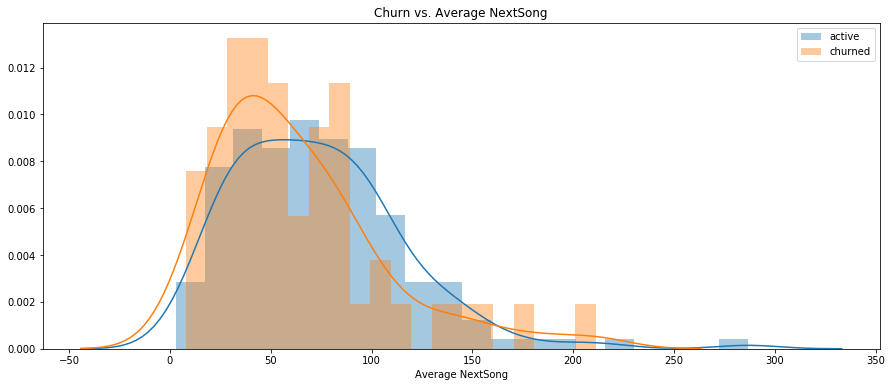

In [1402]:
plot_churn('NextSong', True)

<Figure size 864x288 with 0 Axes>

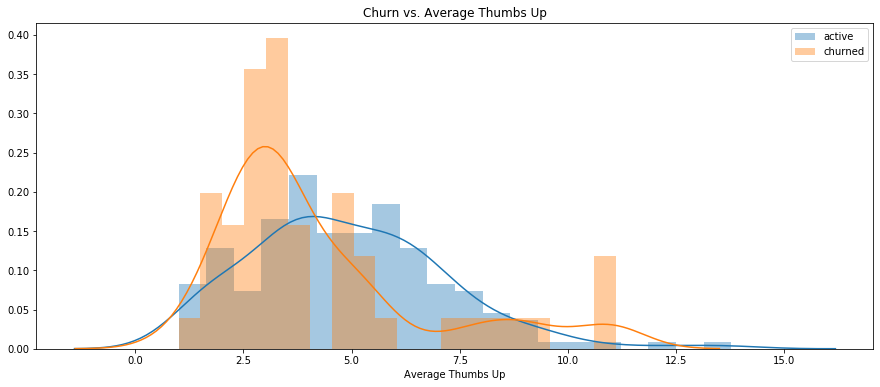

In [1361]:
plot_churn('Thumbs Up')

<Figure size 864x288 with 0 Axes>

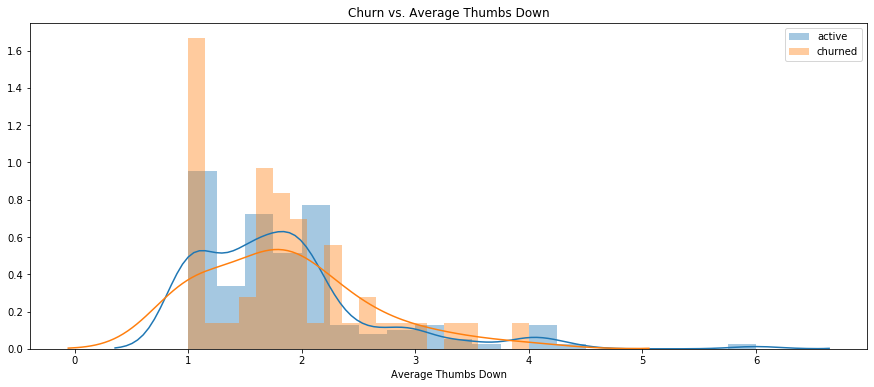

In [1362]:
plot_churn('Thumbs Down')

<Figure size 864x288 with 0 Axes>

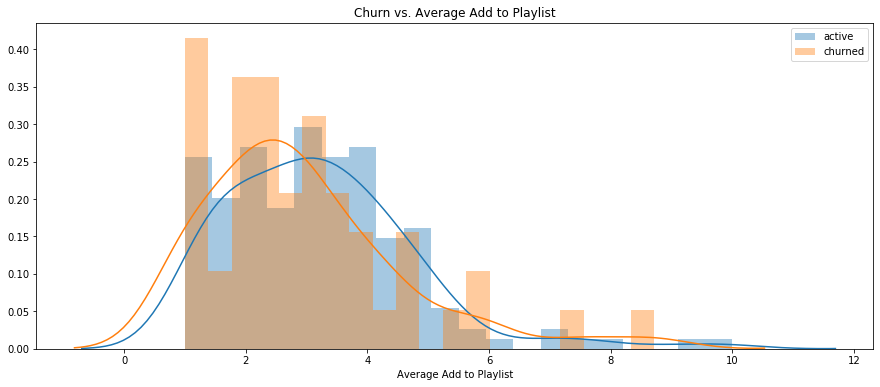

In [1365]:
plot_churn('Add to Playlist')

<Figure size 864x288 with 0 Axes>

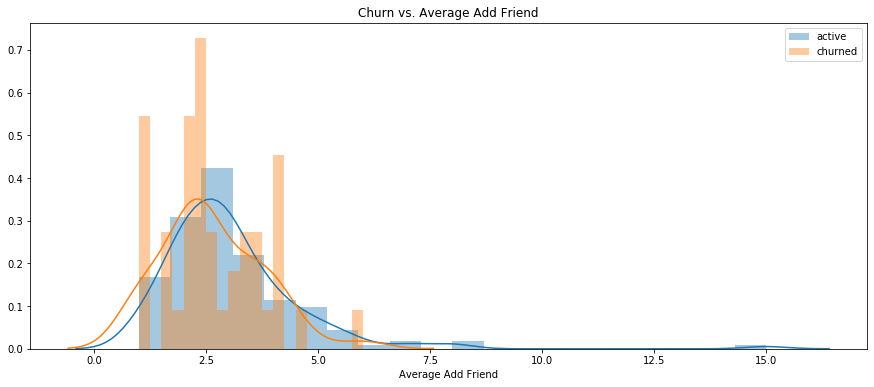

In [1366]:
plot_churn('Add Friend')

<Figure size 864x288 with 0 Axes>

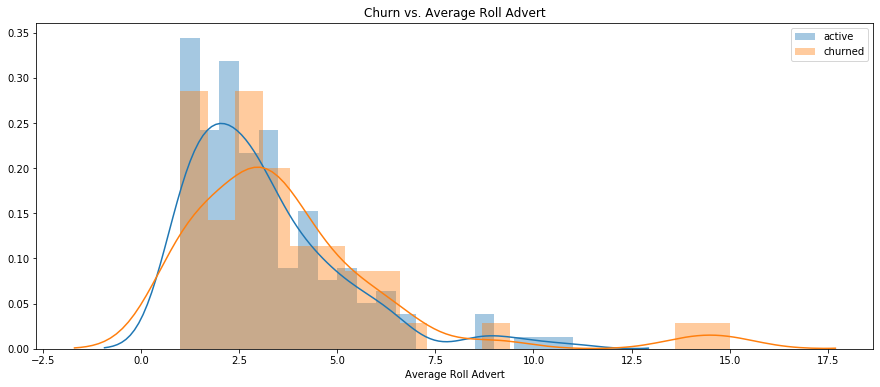

In [1368]:
plot_churn('Roll Advert')

<Figure size 864x288 with 0 Axes>

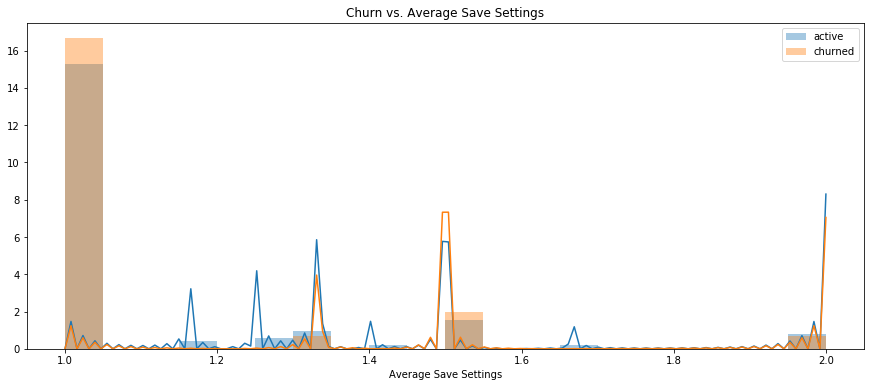

In [1370]:
plot_churn('Save Settings')

In [1372]:
df = get_df('Save Settings')

<Figure size 864x288 with 0 Axes>

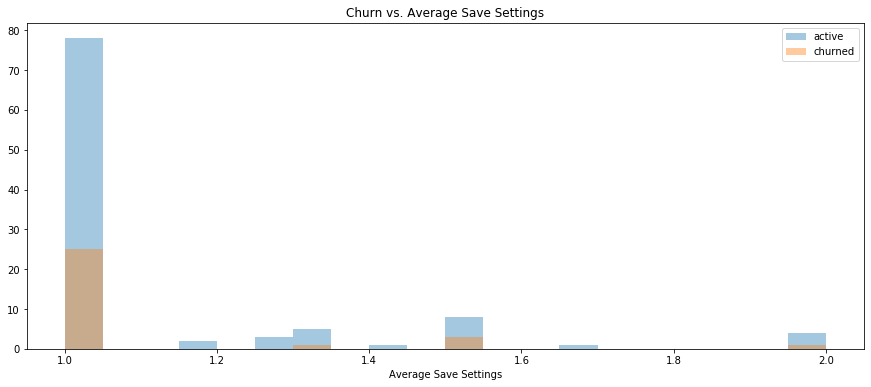

In [1376]:
    page = 'Save Settings'
    kde=False
    plt.figure(figsize=(12, 4))
    df_active = df[df.churn == 0][page]
    df_churned = df[df.churn == 1][page]
    plt.figure(figsize=(15,6));
    sb.distplot(df_active, bins=20, label='active', kde=kde);
    sb.distplot(df_churned, bins=20, label = 'churned', kde=kde);
    plt.xlabel('Average ' + page)
    ax = plt.gca()
    ax.set_title('Churn vs. Average ' + page);
    plt.legend(loc='upper right');
    plt.show()

### Examine Session

In [1142]:
cols = ['sessionId', 'itemInSession', 'userId', 'tsDate', 'page']

In [1143]:
data.select(cols).sort('itemInSession').show(10)

+---------+-------------+------+-------------------+--------+
|sessionId|itemInSession|userId|             tsDate|    page|
+---------+-------------+------+-------------------+--------+
|      149|            0|300009|2018-10-17 11:20:34|NextSong|
|      183|            0|300021|2018-10-18 18:50:46|    Help|
|      173|            0|300023|2018-10-17 16:12:25|NextSong|
|      160|            0|300025|2018-10-17 07:41:52|NextSong|
|      178|            0|300021|2018-10-17 17:24:57|    Home|
|      138|            0|300001|2018-10-18 01:45:39|    Home|
|      179|            0|300009|2018-10-18 17:51:27|NextSong|
|      120|            0|300019|2018-10-18 07:24:43|    Home|
|      166|            0|300011|2018-10-16 20:07:35|    Home|
|       91|            0|300014|2018-10-18 10:46:39|    Home|
+---------+-------------+------+-------------------+--------+
only showing top 10 rows



In [1174]:
# Aggregate a given user by session extracting session's startDate, endDate, end log count
data.where(data.userId == 10) \
    .groupby('userId', 'sessionId') \
    .agg(min('tsDate').alias('startDate'), max('tsDate').alias('endDate'), count('sessionId').alias('logCount')) \
    .sort('sessionId') \
    .show()

+------+---------+-------------------+-------------------+--------+
|userId|sessionId|          startDate|            endDate|logCount|
+------+---------+-------------------+-------------------+--------+
|    10|        9|2018-10-08 04:20:20|2018-10-08 08:16:12|      70|
|    10|      595|2018-10-18 05:38:43|2018-10-19 07:26:38|     449|
|    10|     1047|2018-10-29 23:02:26|2018-10-30 00:33:51|      25|
|    10|     1414|2018-11-03 15:27:42|2018-11-03 19:43:18|      78|
|    10|     1592|2018-11-15 20:34:26|2018-11-16 01:26:29|      78|
|    10|     1981|2018-11-19 08:14:10|2018-11-19 13:49:48|      95|
+------+---------+-------------------+-------------------+--------+



In [1176]:
# Churn vs average number of logs per session
data.groupby('userId', 'sessionId') \
    .count() \
    .show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   73|
|    42|      433|   21|
|   101|      635|  855|
|   120|      627|  261|
|   140|      798|    6|
|   122|      691|    9|
|    29|     1030|   19|
|     8|     1200|   18|
|    96|     1653|  160|
|   153|     1794|   74|
|    97|     2019|   84|
|    35|     2270|   13|
|   110|     1776|   24|
|300011|       60|   36|
|   137|      136|    7|
|    40|      484|   84|
|    35|      544|   16|
|    24|      620|    8|
|    47|       46|    3|
|    85|     1098|   89|
+------+---------+-----+
only showing top 20 rows



In [1222]:
# Churn vs average number of logs per session
df = data.groupby('userId', 'sessionId') \
    .count() \
    .groupby('userId') \
    .agg(avg('count').alias('mean')) \
    .toPandas()

In [1207]:
# Log count per user-session
df = data.groupby('userId', 'sessionId') \
    .agg(count('sessionId')) \
    .show()

+------+---------+----------------+
|userId|sessionId|count(sessionId)|
+------+---------+----------------+
|    92|      358|              73|
|    42|      433|              21|
|   101|      635|             855|
|   120|      627|             261|
|   140|      798|               6|
|   122|      691|               9|
|    29|     1030|              19|
|     8|     1200|              18|
|    96|     1653|             160|
|   153|     1794|              74|
|    97|     2019|              84|
|    35|     2270|              13|
|   110|     1776|              24|
|300011|       60|              36|
|   137|      136|               7|
|    40|      484|              84|
|    35|      544|              16|
|    24|      620|               8|
|    47|       46|               3|
|    85|     1098|              89|
+------+---------+----------------+
only showing top 20 rows



In [1214]:
# Log count per user-session
data.groupby('userId', 'sessionId') \
    .agg(min('churn').alias('churn'), count('sessionId').alias('logCount')) \
    .show()

+------+---------+-----+--------+
|userId|sessionId|churn|logCount|
+------+---------+-----+--------+
|    92|      358|    0|      73|
|    42|      433|    0|      21|
|   101|      635|    1|     855|
|   120|      627|    0|     261|
|   140|      798|    0|       6|
|   122|      691|    1|       9|
|    29|     1030|    1|      19|
|     8|     1200|    0|      18|
|    96|     1653|    0|     160|
|   153|     1794|    0|      74|
|    97|     2019|    0|      84|
|    35|     2270|    0|      13|
|   110|     1776|    0|      24|
|300011|       60|    0|      36|
|   137|      136|    0|       7|
|    40|      484|    0|      84|
|    35|      544|    0|      16|
|    24|      620|    0|       8|
|    47|       46|    0|       3|
|    85|     1098|    0|      89|
+------+---------+-----+--------+
only showing top 20 rows



### Session Activity

In [1330]:
# Prepare dataset
df = data.groupby('userId', 'churn', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), ((max('ts') - min('ts'))/60000.0).alias('duration')) \
    .groupby('userId', 'churn') \
    .agg(avg('logCount').alias('avgLogsPerSession'), \
         avg('duration').alias('avgDurationPerSession')) \
    .toPandas()

#### Average logs per session 

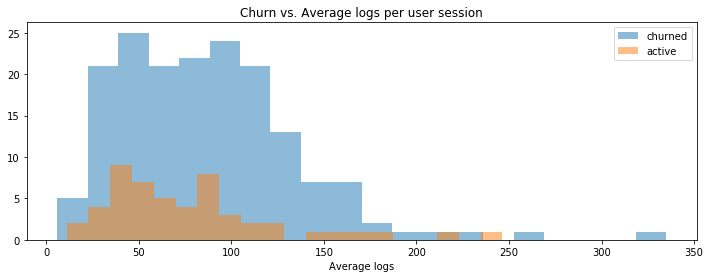

In [1333]:
plt.figure(figsize=(12, 4))
plt.hist(df[df.churn == 0]['avgLogsPerSession'], alpha = 0.5, label="churned", bins = 20)
plt.hist(df[df.churn == 1]['avgLogsPerSession'], alpha = 0.5, label="active", bins = 20)
plt.xlabel('Average logs')
ax = plt.gca()
ax.set_title('Churn vs. Average logs per user session');
plt.legend(loc='upper right')
plt.show()

#### Average duration per session 

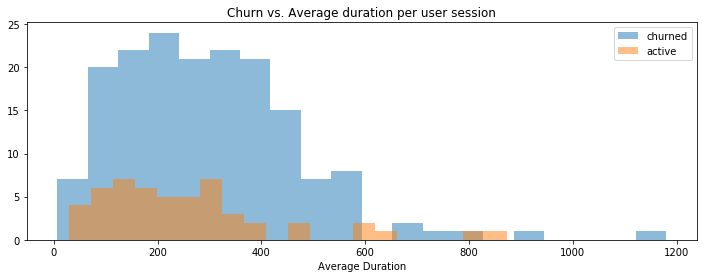

In [1335]:
plt.figure(figsize=(12, 4))
plt.hist(df[df.churn == 0]['avgDurationPerSession'], alpha = 0.5, label="churned", bins = 20)
plt.hist(df[df.churn == 1]['avgDurationPerSession'], alpha = 0.5, label="active", bins = 20)
plt.xlabel('Average Duration')
ax = plt.gca()
ax.set_title('Churn vs. Average duration per user session');
plt.legend(loc='upper right')
plt.show()

### 1st Level Aggregation: by churn

count: *gender*, *level*, *state*
avg: *logCount*, *duration*, **  

In [ ]:
agg1 = data \
    .groupby('churn')
    .agg()

In [1403]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- churn: integer (nullable = true)



In [ ]:
# Prepare dataset
df = data.groupby('userId', 'churn', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), ((max('ts') - min('ts'))/60000.0).alias('duration')) \
    .groupby('userId', 'churn') \
    .agg(avg('logCount').alias('avgLogsPerSession'), \
         avg('duration').alias('avgDurationPerSession')) \
    .toPandas()

In [1411]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- churn: integer (nullable = true)



### Window Function

In [496]:
from pyspark.sql.functions import row_number

data2 = data.select('userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status',
        row_number().over(w).alias("rown"))

In [530]:
# GET CHURNED USERS
users = data \
    .where(data.page.isin(['Submit Downgrade', 'Cancellation Confirmation'])) \
    .select('userId') \
    .dropDuplicates() \
    .collect()

# list of userIds
uids = [x.userId for x in users];

# Window
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc())
data2 = data.select('userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status',
        row_number().over(w).alias("rown"))
    
# final query
data2 \
    .where(data2.rown == 1) \
    .where(data2.userId.isin(uids)) \
    .where((data2.level == 'free') | (data2.page == 'Cancellation Confirmation')) \
    .count()



67

In [ ]:
overUser = window.partitionBy('userId')
w = data.withColumn(
  "rown", array_contains('userId', 'tsDate', 'auth', 'level', 'page', 'status') over overUser).withColumn(
  "total_salary_in_dep", sum('salary) over overCategory)
df.show()

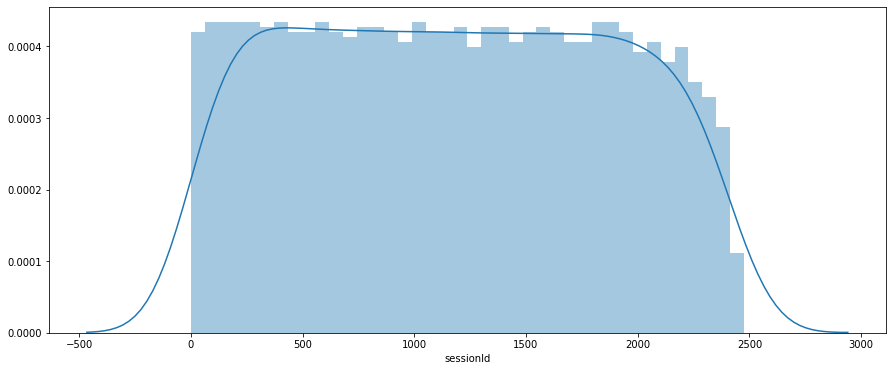

In [1195]:
df = data.groupby('sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('sessionId', round(col('duration'), 1).alias('duration')) \
    .toPandas()
plt.figure(figsize=(15,6))
sb.distplot(df['sessionId'], bins=40)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.